<a href="https://colab.research.google.com/github/RomainGratier/Black-box_Optimization_via_Deep_Generative-Exploratory_Networks/blob/master/notebooks/CGANtest_thickness_continuous_mnist_FID_w_o_weighting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
d=[]
while(1):
  d.append('1')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [ ]:
!git clone https://github.com/dccastro/Morpho-MNIST.git
!cp -r Morpho-MNIST/morphomnist morphomnist

!git clone https://github.com/abdulfatir/gan-metrics-pytorch.git
!cp -r gan-metrics-pytorch/models models

!git clone https://github.com/RomainGratier/Black-box_Optimization_via_Deep_Generative-Exploratory_Networks.git
!cp -r Black-box_Optimization_via_Deep_Generative-Exploratory_Networks/src src

# SEED EVERYTHING
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd 
import random

import os 
from copy import deepcopy
import shutil

import matplotlib.pyplot as plt


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Cloning into 'Morpho-MNIST'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 531 (delta 3), reused 2 (delta 1), pack-reused 521
Receiving objects: 100% (531/531), 154.11 KiB | 417.00 KiB/s, done.
Resolving deltas: 100% (305/305), done.
Cloning into 'gan-metrics-pytorch'...
remote: Enumerating objects: 69, done.
remote: Total 69 (delta 0), reused 0 (delta 0), pack-reused 69
Unpacking objects: 100% (69/69), done.
Cloning into 'Black-box_Optimization_via_Deep_Generative-Exploratory_Networks'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 185 (delta 92), reused 92 (delta 26), pack-reused 0
Receiving objects: 100% (185/185), 20.20 MiB | 8.74 MiB/s, done.
Resolving deltas: 100% (92/92), done.


# Set up the main variables

In [ ]:
n_epochs = 200
batch_size = 128
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
label_dim_input=1 #14
img_size=28
channels=1
sample_interval=1000
n_row = 10

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

# Create the classes for the models and the dataset

In [ ]:
from src.models import Generator, Discriminator, LeNet5
from src.data import MNISTDataset
from src.metrics import calculate_fid_given_paths
from src.models import sample_image, save_model_check

### Create the dataset

 ---------------------------------------- CHECK NANS
Empty DataFrame
Columns: [index, area, length, thickness, slant, width, height, digit]
Index: []
              index          area  ...        height         digit
count  54251.000000  54251.000000  ...  54251.000000  54251.000000
mean   30149.049160     97.446472  ...     18.977384      4.475641
std    17335.099438     61.981228  ...      1.727615      2.880369
min        0.000000      4.875000  ...      6.165503      0.000000
25%    15185.500000     44.375000  ...     18.104972      2.000000
50%    30258.000000     85.812500  ...     19.210691      4.000000
75%    45199.500000    138.000000  ...     19.916090      7.000000
max    59999.000000    347.000000  ...     22.820397      9.000000

[8 rows x 8 columns]
 -------------------- EDA -------------------- 

The extrem values from our labels:
Maximum : 5.999531638467404   Minimum : 0.7132510119321792

Check the distribution of our labels
thickness
0      906
1    21099
2    12704
3

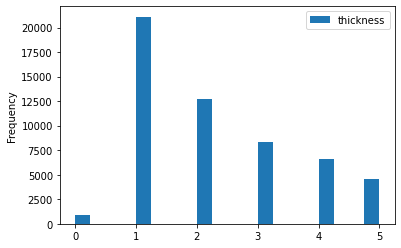

In [ ]:
dataset = MNISTDataset('train', 'thickness')


 ---------------------------------------- CHECK NANS
Empty DataFrame
Columns: [index, area, length, thickness, slant, width, height, digit]
Index: []
              index          area  ...        height         digit
count  54251.000000  54251.000000  ...  54251.000000  54251.000000
mean   30149.049160     97.446472  ...     18.977384      4.475641
std    17335.099438     61.981228  ...      1.727615      2.880369
min        0.000000      4.875000  ...      6.165503      0.000000
25%    15185.500000     44.375000  ...     18.104972      2.000000
50%    30258.000000     85.812500  ...     19.210691      4.000000
75%    45199.500000    138.000000  ...     19.916090      7.000000
max    59999.000000    347.000000  ...     22.820397      9.000000

[8 rows x 8 columns]
 -------------------- EDA -------------------- 

The extrem values from our labels:
Maximum : 5.999531638467404   Minimum : 0.7132510119321792

Check the distribution of our labels
thickness
0      906
1    21099
2    12704
3

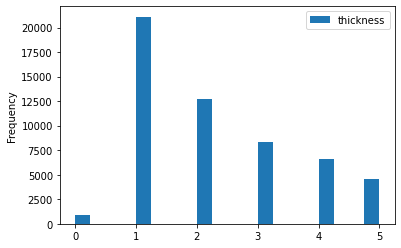

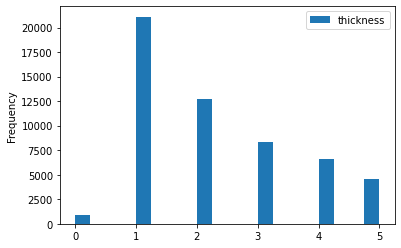

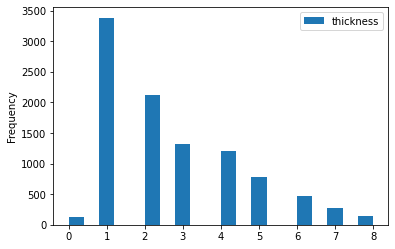

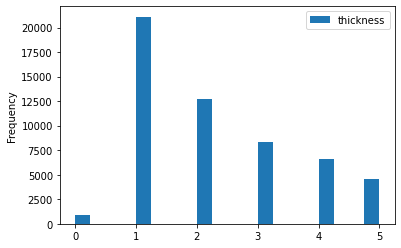

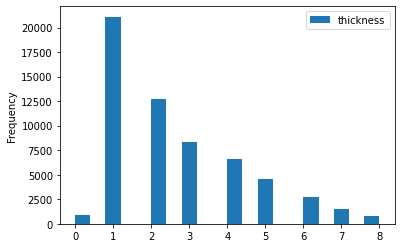

In [ ]:
## GAN
dataloader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

# Forward
trainset = MNISTDataset('train', 'thickness')
trainloader = DataLoader(dataset=trainset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

testset = MNISTDataset('test', 'thickness')
testloader = DataLoader(dataset=testset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

# Inference
fulldataset = MNISTDataset('full', 'thickness')

### Define the main parameters to train the Generative Adversarial Network

In [ ]:
path_generator = '/content/drive/My Drive/master_thesis/models/generative_wo_weight/'

def load_obj_csv(path):
    return pd.read_csv(path+'.csv')

def save_obj_csv(d, path):
    d.to_csv(path+'.csv', index=False)

def train_loop():

    mse_gan_in_distribution = []
    mse_gan_out_distribution = []
    df_acc_gen = pd.DataFrame(columns=['mse_in', 'mse_out', 'fid_in', 'fid_out'])

    path_generator = '/content/drive/My Drive/master_thesis/models/generative/'
    if os.path.exists(path_generator):
        df_check_in_distribution = load_obj_csv(os.path.join(path_generator, 'results_in_distribution'))
        df_check_out_distribution = load_obj_csv(os.path.join(path_generator, 'results_out_distribution'))
    else:
        os.makedirs(path_generator)
        df_check_in_distribution = None
        df_check_out_distribution = None

    # Loss functions
    adversarial_loss = torch.nn.MSELoss()

    # Initialize generator and discriminator
    generator = Generator()
    discriminator = Discriminator()


    if cuda:
        generator.cuda()
        discriminator.cuda()
        adversarial_loss.cuda()

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

    FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

    if os.path.isdir("images"):
        shutil.rmtree("images")
    os.makedirs("images", exist_ok=True)

    # FID needs
    df_test = pd.DataFrame(np.around(testset.y_data.numpy(),1), columns=['label'])
    index_in_distribution = df_test[df_test['label']<=dataset.maximum].index
    index_out_distribution = df_test[df_test['label']>dataset.maximum].index
    real_dataset = deepcopy(testset.x_data)

    arr = np.array([num for num in np.arange(0, 1, 1/n_row)])
    print(f"Checkup the plots of the displayed labels {arr}")
    in_distribution_index = np.where(arr <= dataset.maximum)
    out_distribution_index = np.where(arr > dataset.maximum)

    best_res_in = 100000
    best_res_out = 100000

    for epoch in range(n_epochs):
        for i, (imgs, labels) in enumerate(dataloader):
            ## Initialization
            batch_size = imgs.shape[0]

            # Adversarial ground truths
            valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
            fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

            # Configure input
            real_imgs = Variable(imgs.type(FloatTensor))
            labels = Variable(labels.type(FloatTensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise and labels as generator input
            z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
            gen_labels = Variable(FloatTensor(np.random.rand(batch_size))) 

            # Generate a batch of images
            gen_imgs = generator(z, gen_labels)

            # Loss measures generator's ability to fool the discriminator
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)

            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            batches_done = epoch * len(dataloader) + i
            if batches_done % sample_interval == 0:

                print(
                  "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                  % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
                )

                # Delete useless data from GPU
                del valid; del fake; del real_imgs; del labels; del z; del gen_labels; del g_loss; del d_loss; del gen_imgs; del validity;
                torch.cuda.empty_cache()

                mse_gan, fid_in, fid_out = sample_image(n_row, batches_done, in_distribution_index, out_distribution_index, index_in_distribution, index_out_distribution, generator, dataset, real_dataset, 700)

                mean_in_mse = np.mean(mse_gan[in_distribution_index])
                mean_out_mse = np.mean(mse_gan[out_distribution_index])

                mse_gan_in_distribution.append(mse_gan[in_distribution_index])
                mse_gan_out_distribution.append(mse_gan[out_distribution_index])

                df = pd.DataFrame([mean_in_mse], columns=['mse_in'])
                df['mse_out'] = mean_out_mse
                df['fid_in'] = fid_in
                df['fid_out'] = fid_out

                df_acc_gen = df_acc_gen.append(df, ignore_index=True)

                # Check if we have better results
                df_check_in_distribution, best_res_in = save_model_check('in', df_check_in_distribution, df['mse_in'].values, best_res_in, df_acc_gen, path_generator)
                df_check_out_distribution, best_res_out = save_model_check('out', df_check_out_distribution, df['mse_out'].values, best_res_out, df_acc_gen, path_generator)

    return mse_gan_in_distribution, mse_gan_out_distribution, df_acc_gen

!nvidia-smi

Wed Apr  8 10:13:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    719MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Training loop GAN




In [ ]:
mse_gan_in_distribution, mse_gan_out_distribution, df_acc_gen = train_loop()

Checkup the plots of the displayed labels [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[Epoch 0/200] [Batch 0/424] [D loss: 0.459497] [G loss: 0.887410]


100%|##########| 100/100 [00:12<00:00,  7.70img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.8181486 0.9703498


FID: 100%|██████████| 10/10 [00:00<00:00, 34.36it/s, mean=116]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.8278992 0.97755337


FID: 100%|██████████| 10/10 [00:00<00:00, 35.74it/s, mean=84]



The thickness distribution =
[0.11175988 0.11868765 0.11750507 0.11517463 0.10276803 0.11007593
 0.11786676 0.10984083 0.13001226 0.10437984]
Average MSE In dist = 5.807009787223807 \ Average MSE Out dist = 28.722533168700366
FID score in distribution : mean = 115.6022 \ std = 1.1201
FID score out distribution : mean = 84.0156 \ std = 1.224
[Epoch 2/200] [Batch 152/424] [D loss: 0.212992] [G loss: 0.971088]


100%|##########| 100/100 [00:11<00:00,  9.03img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 5.2154064e-08 0.9999995


FID: 100%|██████████| 10/10 [00:00<00:00, 27.04it/s, mean=28.8]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 1.3038516e-08 0.99999595


FID: 100%|██████████| 10/10 [00:00<00:00, 29.33it/s, mean=23.1]



The thickness distribution =
[0.1024111  0.10632026 0.05377896 0.07939865 0.06938556 0.09211821
 0.13275789 0.09822848 0.10487845 0.12377267]
Average MSE In dist = 6.216902390599949 \ Average MSE Out dist = 28.824155610496213
FID score in distribution : mean = 28.8082 \ std = 0.4524
FID score out distribution : mean = 23.1332 \ std = 0.6656
[Epoch 4/200] [Batch 304/424] [D loss: 0.101542] [G loss: 0.555652]


100%|##########| 100/100 [00:13<00:00,  7.48img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999997


FID: 100%|██████████| 10/10 [00:00<00:00, 26.89it/s, mean=19.1]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999997


FID: 100%|██████████| 10/10 [00:00<00:00, 32.68it/s, mean=24.3]



The thickness distribution =
[0.0943191  0.1038387  0.13607458 0.09832586 0.1063496  0.09364528
 0.10926254 0.11407694 0.14117772 0.09542836]
Average MSE In dist = 5.901391161202974 \ Average MSE Out dist = 28.708922079167912
FID score in distribution : mean = 19.0566 \ std = 0.8029
FID score out distribution : mean = 24.2779 \ std = 0.8514
[Epoch 7/200] [Batch 32/424] [D loss: 0.167365] [G loss: 0.893014]


100%|##########| 100/100 [00:13<00:00,  7.30img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999744


FID: 100%|██████████| 10/10 [00:00<00:00, 30.97it/s, mean=13.1]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999917


FID: 100%|██████████| 10/10 [00:00<00:00, 28.54it/s, mean=17.2]



The thickness distribution =
[0.15216242 0.10750793 0.15137763 0.1181018  0.13353124 0.13820189
 0.17666837 0.1190721  0.17708089 0.15805421]
Average MSE In dist = 5.158685501440714 \ Average MSE Out dist = 24.915944104557667
FID score in distribution : mean = 13.0799 \ std = 0.5741
FID score out distribution : mean = 17.2081 \ std = 0.8678
[Epoch 9/200] [Batch 184/424] [D loss: 0.122512] [G loss: 0.547483]


100%|##########| 100/100 [00:12<00:00,  7.74img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999493


FID: 100%|██████████| 10/10 [00:00<00:00, 28.08it/s, mean=16.6]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999871


FID: 100%|██████████| 10/10 [00:00<00:00, 27.45it/s, mean=11.6]



The thickness distribution =
[0.08411461 0.0954718  0.11800341 0.15753729 0.17619762 0.18943929
 0.24100448 0.29844687 0.32660049 0.33351335]
Average MSE In dist = 3.124562224786108 \ Average MSE Out dist = 14.469231198820339
FID score in distribution : mean = 16.5762 \ std = 1.0312
FID score out distribution : mean = 11.5852 \ std = 0.7614
[Epoch 11/200] [Batch 336/424] [D loss: 0.141115] [G loss: 0.598004]


100%|##########| 100/100 [00:12<00:00,  8.24img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99998677


FID: 100%|██████████| 10/10 [00:00<00:00, 32.11it/s, mean=10.6]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999906


FID: 100%|██████████| 10/10 [00:00<00:00, 28.87it/s, mean=9.71]



The thickness distribution =
[0.08869615 0.1262865  0.14026885 0.17395951 0.18962972 0.23343011
 0.27018911 0.32124603 0.32049013 0.35368212]
Average MSE In dist = 2.625346658464312 \ Average MSE Out dist = 14.027963668966713
FID score in distribution : mean = 10.5819 \ std = 0.5369
FID score out distribution : mean = 9.7144 \ std = 0.7381
[Epoch 14/200] [Batch 64/424] [D loss: 0.136851] [G loss: 0.658891]


100%|##########| 100/100 [00:13<00:00,  7.33img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999842


FID: 100%|██████████| 10/10 [00:00<00:00, 26.47it/s, mean=11.8]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999285


FID: 100%|██████████| 10/10 [00:00<00:00, 30.16it/s, mean=8.95]



The thickness distribution =
[0.07092393 0.09986282 0.15483518 0.19663979 0.21793128 0.24630672
 0.26891605 0.33857033 0.30027105 0.368793  ]
Average MSE In dist = 2.359556129947504 \ Average MSE Out dist = 14.121333056326822
FID score in distribution : mean = 11.8117 \ std = 0.5166
FID score out distribution : mean = 8.9538 \ std = 0.8561
[Epoch 16/200] [Batch 216/424] [D loss: 0.148151] [G loss: 0.504155]


100%|##########| 100/100 [00:12<00:00,  7.73img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999995


FID: 100%|██████████| 10/10 [00:00<00:00, 30.67it/s, mean=8.18]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999995


FID: 100%|██████████| 10/10 [00:00<00:00, 32.33it/s, mean=8.19]



The thickness distribution =
[0.07740103 0.12075866 0.17857514 0.18143814 0.28851204 0.27710943
 0.32864623 0.30765806 0.35783808 0.34357179]
Average MSE In dist = 2.0615635628590554 \ Average MSE Out dist = 13.410092382930529
FID score in distribution : mean = 8.175 \ std = 0.5201
FID score out distribution : mean = 8.1896 \ std = 0.9264
[Epoch 18/200] [Batch 368/424] [D loss: 0.160910] [G loss: 0.447738]


100%|##########| 100/100 [00:12<00:00,  7.94img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999987


FID: 100%|██████████| 10/10 [00:00<00:00, 26.60it/s, mean=8.08]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999465


FID: 100%|██████████| 10/10 [00:00<00:00, 29.80it/s, mean=7.3]



The thickness distribution =
[0.07361441 0.09831151 0.13763047 0.19957895 0.21641223 0.31335593
 0.31271619 0.357716   0.36802608 0.41970503]
Average MSE In dist = 1.9090064590973745 \ Average MSE Out dist = 11.078223143190034
FID score in distribution : mean = 8.0789 \ std = 0.9624
FID score out distribution : mean = 7.3037 \ std = 1.1313
[Epoch 21/200] [Batch 96/424] [D loss: 0.162479] [G loss: 0.431169]


100%|##########| 100/100 [00:12<00:00,  7.87img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99998796


FID: 100%|██████████| 10/10 [00:00<00:00, 30.58it/s, mean=6.27]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999991


FID: 100%|██████████| 10/10 [00:00<00:00, 29.47it/s, mean=6.59]



The thickness distribution =
[0.06412837 0.10765839 0.17487803 0.18848187 0.30865321 0.28722325
 0.35260394 0.38942332 0.38420492 0.45499139]
Average MSE In dist = 1.516703377240899 \ Average MSE Out dist = 9.84726850146977
FID score in distribution : mean = 6.2694 \ std = 0.5165
FID score out distribution : mean = 6.5912 \ std = 0.806
[Epoch 23/200] [Batch 248/424] [D loss: 0.137768] [G loss: 0.566132]


100%|##########| 100/100 [00:13<00:00,  7.59img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999833


FID: 100%|██████████| 10/10 [00:00<00:00, 31.93it/s, mean=5.9]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999666


FID: 100%|██████████| 10/10 [00:00<00:00, 34.50it/s, mean=6.84]



The thickness distribution =
[0.08576168 0.10843343 0.19889261 0.20401607 0.25320596 0.30535782
 0.34015318 0.41301243 0.41308731 0.4047685 ]
Average MSE In dist = 1.4996942316258393 \ Average MSE Out dist = 10.485423408126078
FID score in distribution : mean = 5.8991 \ std = 0.3802
FID score out distribution : mean = 6.8399 \ std = 0.8232
[Epoch 25/200] [Batch 400/424] [D loss: 0.149323] [G loss: 0.567512]


100%|##########| 100/100 [00:14<00:00,  7.03img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999965


FID: 100%|██████████| 10/10 [00:00<00:00, 27.57it/s, mean=6.09]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.999995


FID: 100%|██████████| 10/10 [00:00<00:00, 31.34it/s, mean=7.09]



The thickness distribution =
[0.0612658  0.10825384 0.17454725 0.23333335 0.27851753 0.33503774
 0.34614392 0.35743477 0.44421225 0.38646989]
Average MSE In dist = 1.544306497939641 \ Average MSE Out dist = 10.361772506495639
FID score in distribution : mean = 6.0937 \ std = 0.5859
FID score out distribution : mean = 7.0851 \ std = 0.6497
[Epoch 28/200] [Batch 128/424] [D loss: 0.127759] [G loss: 0.592740]


100%|##########| 100/100 [00:14<00:00,  6.91img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99998736


FID: 100%|██████████| 10/10 [00:00<00:00, 29.20it/s, mean=5.87]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999595


FID: 100%|██████████| 10/10 [00:00<00:00, 32.24it/s, mean=6.73]



The thickness distribution =
[0.05883571 0.09702266 0.1689314  0.23090122 0.27456692 0.34424568
 0.3839384  0.37067192 0.47846411 0.49899006]
Average MSE In dist = 1.3562417828605344 \ Average MSE Out dist = 7.013924159950019
FID score in distribution : mean = 5.872 \ std = 0.3435
FID score out distribution : mean = 6.7267 \ std = 0.8268
[Epoch 30/200] [Batch 280/424] [D loss: 0.173013] [G loss: 0.469656]


100%|##########| 100/100 [00:12<00:00,  7.78img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999404


FID: 100%|██████████| 10/10 [00:00<00:00, 26.76it/s, mean=4.89]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99998856


FID: 100%|██████████| 10/10 [00:00<00:00, 32.40it/s, mean=6.6]



The thickness distribution =
[0.071549   0.09214931 0.16890057 0.24761506 0.32438891 0.34084771
 0.44758222 0.44757618 0.41580752 0.44961426]
Average MSE In dist = 0.84216497574667 \ Average MSE Out dist = 9.303902431506184
FID score in distribution : mean = 4.8853 \ std = 0.4625
FID score out distribution : mean = 6.5962 \ std = 0.8548
[Epoch 33/200] [Batch 8/424] [D loss: 0.138150] [G loss: 0.617176]


100%|##########| 100/100 [00:12<00:00,  7.69img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999981


FID: 100%|██████████| 10/10 [00:00<00:00, 31.11it/s, mean=5.53]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.999998


FID: 100%|██████████| 10/10 [00:00<00:00, 32.39it/s, mean=6.73]



The thickness distribution =
[0.06808546 0.10400318 0.18446863 0.24440304 0.3144669  0.35637979
 0.42522752 0.39302111 0.47058891 0.47502074]
Average MSE In dist = 1.0666335451598874 \ Average MSE Out dist = 7.6756348923568165
FID score in distribution : mean = 5.5313 \ std = 0.5071
FID score out distribution : mean = 6.726 \ std = 0.6552
[Epoch 35/200] [Batch 160/424] [D loss: 0.124550] [G loss: 0.631011]


100%|##########| 100/100 [00:12<00:00,  8.24img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999951


FID: 100%|██████████| 10/10 [00:00<00:00, 33.97it/s, mean=5.49]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999905


FID: 100%|██████████| 10/10 [00:00<00:00, 27.08it/s, mean=6.18]



The thickness distribution =
[0.0838476  0.0994924  0.19242463 0.24459384 0.28472699 0.34090416
 0.41819913 0.38416101 0.4640242  0.40737169]
Average MSE In dist = 1.205050361260056 \ Average MSE Out dist = 9.43959653616527
FID score in distribution : mean = 5.493 \ std = 0.6453
FID score out distribution : mean = 6.1846 \ std = 0.6677
[Epoch 37/200] [Batch 312/424] [D loss: 0.138661] [G loss: 0.573743]


100%|##########| 100/100 [00:12<00:00,  7.74img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999954


FID: 100%|██████████| 10/10 [00:00<00:00, 30.68it/s, mean=4.84]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999205


FID: 100%|██████████| 10/10 [00:00<00:00, 27.78it/s, mean=6.59]



The thickness distribution =
[0.07201556 0.10701634 0.15392437 0.26238594 0.30909858 0.36405921
 0.43745211 0.34040757 0.4174178  0.50008858]
Average MSE In dist = 1.2693083991122232 \ Average MSE Out dist = 8.131715605734628
FID score in distribution : mean = 4.8426 \ std = 0.5047
FID score out distribution : mean = 6.5939 \ std = 0.8646
[Epoch 40/200] [Batch 40/424] [D loss: 0.133641] [G loss: 0.579675]


100%|##########| 100/100 [00:13<00:00,  7.46img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999926


FID: 100%|██████████| 10/10 [00:00<00:00, 29.18it/s, mean=6.18]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999854


FID: 100%|██████████| 10/10 [00:00<00:00, 29.74it/s, mean=5.37]



The thickness distribution =
[0.07167437 0.12188751 0.16833815 0.26635198 0.38056702 0.39758442
 0.44337249 0.43899476 0.45646488 0.43756772]
Average MSE In dist = 0.7385317235073602 \ Average MSE Out dist = 8.810337196197016
FID score in distribution : mean = 6.1814 \ std = 0.783
FID score out distribution : mean = 5.3714 \ std = 0.4442
[Epoch 42/200] [Batch 192/424] [D loss: 0.155388] [G loss: 0.460730]


100%|##########| 100/100 [00:11<00:00,  8.38img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999922


FID: 100%|██████████| 10/10 [00:00<00:00, 31.85it/s, mean=4.93]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999669


FID: 100%|██████████| 10/10 [00:00<00:00, 28.56it/s, mean=6.49]



The thickness distribution =
[0.07892247 0.12078636 0.17793467 0.23649264 0.30750602 0.34724852
 0.40355932 0.37699311 0.39220883 0.39326322]
Average MSE In dist = 1.23444169889237 \ Average MSE Out dist = 11.231966707242803
FID score in distribution : mean = 4.9341 \ std = 0.3365
FID score out distribution : mean = 6.4922 \ std = 0.6695
[Epoch 44/200] [Batch 344/424] [D loss: 0.150137] [G loss: 0.702580]


100%|##########| 100/100 [00:13<00:00,  7.35img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999887


FID: 100%|██████████| 10/10 [00:00<00:00, 27.76it/s, mean=5.03]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999949


FID: 100%|██████████| 10/10 [00:00<00:00, 28.33it/s, mean=5.87]



The thickness distribution =
[0.07093104 0.11493162 0.1742478  0.25271507 0.34423035 0.39711645
 0.38785911 0.43037596 0.46004651 0.42960413]
Average MSE In dist = 0.926201528642715 \ Average MSE Out dist = 8.942565263972508
FID score in distribution : mean = 5.0333 \ std = 0.6168
FID score out distribution : mean = 5.8736 \ std = 0.5334
[Epoch 47/200] [Batch 72/424] [D loss: 0.130901] [G loss: 0.655765]


100%|##########| 100/100 [00:12<00:00,  8.02img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 31.07it/s, mean=5.48]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999946


FID: 100%|██████████| 10/10 [00:00<00:00, 33.13it/s, mean=6.22]



The thickness distribution =
[0.07073988 0.10148344 0.16967588 0.26899008 0.32711236 0.39510035
 0.44710292 0.46760784 0.54601449 0.52919291]
Average MSE In dist = 0.667609330512439 \ Average MSE Out dist = 5.362941466589463
FID score in distribution : mean = 5.4823 \ std = 0.3446
FID score out distribution : mean = 6.2245 \ std = 0.5096
[Epoch 49/200] [Batch 224/424] [D loss: 0.138493] [G loss: 0.530065]


100%|##########| 100/100 [00:13<00:00,  7.64img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999951


FID: 100%|██████████| 10/10 [00:00<00:00, 27.33it/s, mean=6.54]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999999


FID: 100%|██████████| 10/10 [00:00<00:00, 31.25it/s, mean=6.69]



The thickness distribution =
[0.06752536 0.10812544 0.19233659 0.27568919 0.38043598 0.40503047
 0.51889564 0.40812024 0.42342031 0.3629247 ]
Average MSE In dist = 0.7065122387551933 \ Average MSE Out dist = 11.422752228246317
FID score in distribution : mean = 6.5381 \ std = 0.7227
FID score out distribution : mean = 6.6911 \ std = 0.412
[Epoch 51/200] [Batch 376/424] [D loss: 0.165245] [G loss: 0.616717]


100%|##########| 100/100 [00:11<00:00,  8.56img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999975


FID: 100%|██████████| 10/10 [00:00<00:00, 31.37it/s, mean=4.13]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999949


FID: 100%|██████████| 10/10 [00:00<00:00, 30.67it/s, mean=7.04]



The thickness distribution =
[0.06052998 0.09770226 0.16933931 0.27283077 0.34777571 0.43027648
 0.42105701 0.41780566 0.45971599 0.52276396]
Average MSE In dist = 0.826917473212573 \ Average MSE Out dist = 6.852136792039894
FID score in distribution : mean = 4.1328 \ std = 0.3942
FID score out distribution : mean = 7.0368 \ std = 0.7462
[Epoch 54/200] [Batch 104/424] [D loss: 0.142064] [G loss: 0.554669]


100%|##########| 100/100 [00:13<00:00,  7.40img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999994


FID: 100%|██████████| 10/10 [00:00<00:00, 32.46it/s, mean=5.06]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999964


FID: 100%|██████████| 10/10 [00:00<00:00, 30.73it/s, mean=5.41]



The thickness distribution =
[0.07585835 0.10408387 0.17840328 0.27199636 0.33327276 0.47453573
 0.42833666 0.37738966 0.39509624 0.36145362]
Average MSE In dist = 0.9668146558323264 \ Average MSE Out dist = 12.052402671400056
FID score in distribution : mean = 5.0636 \ std = 0.5193
FID score out distribution : mean = 5.4093 \ std = 0.3398
[Epoch 56/200] [Batch 256/424] [D loss: 0.125514] [G loss: 0.661180]


100%|##########| 100/100 [00:13<00:00,  7.50img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99995327


FID: 100%|██████████| 10/10 [00:00<00:00, 32.30it/s, mean=4.23]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999844


FID: 100%|██████████| 10/10 [00:00<00:00, 28.37it/s, mean=6.06]



The thickness distribution =
[0.05713782 0.08607594 0.1419704  0.27064813 0.36739275 0.41240587
 0.45705294 0.50813328 0.4604556  0.44382716]
Average MSE In dist = 0.4889559272650893 \ Average MSE Out dist = 8.58531504092873
FID score in distribution : mean = 4.2317 \ std = 0.5879
FID score out distribution : mean = 6.0631 \ std = 0.5063
[Epoch 58/200] [Batch 408/424] [D loss: 0.156698] [G loss: 0.533206]


100%|##########| 100/100 [00:13<00:00,  7.46img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999658


FID: 100%|██████████| 10/10 [00:00<00:00, 27.09it/s, mean=4.5]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999972


FID: 100%|██████████| 10/10 [00:00<00:00, 27.25it/s, mean=8.61]



The thickness distribution =
[0.06501465 0.13190791 0.19952122 0.27892575 0.40700277 0.41091685
 0.43513514 0.51737306 0.41036682 0.39652357]
Average MSE In dist = 0.4925200559515854 \ Average MSE Out dist = 10.760115595268477
FID score in distribution : mean = 4.5032 \ std = 0.4766
FID score out distribution : mean = 8.6133 \ std = 0.711
[Epoch 61/200] [Batch 136/424] [D loss: 0.196523] [G loss: 0.657248]


100%|##########| 100/100 [00:14<00:00,  7.03img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999166


FID: 100%|██████████| 10/10 [00:00<00:00, 27.22it/s, mean=4.45]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999994


FID: 100%|██████████| 10/10 [00:00<00:00, 28.12it/s, mean=6.34]



The thickness distribution =
[0.07602122 0.09853071 0.18528711 0.29947059 0.34954393 0.38526757
 0.44516678 0.43017406 0.4168787  0.3467281 ]
Average MSE In dist = 0.7864077160259798 \ Average MSE Out dist = 12.023530389025042
FID score in distribution : mean = 4.4521 \ std = 0.3517
FID score out distribution : mean = 6.3431 \ std = 0.7171
[Epoch 63/200] [Batch 288/424] [D loss: 0.146451] [G loss: 0.538479]


100%|##########| 100/100 [00:12<00:00,  7.81img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999845


FID: 100%|██████████| 10/10 [00:00<00:00, 27.31it/s, mean=3.64]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999964


FID: 100%|██████████| 10/10 [00:00<00:00, 28.40it/s, mean=6.44]



The thickness distribution =
[0.05507492 0.1085917  0.17937632 0.28251574 0.3528787  0.4250329
 0.43023225 0.48220109 0.43728879 0.35607355]
Average MSE In dist = 0.5836392763229198 \ Average MSE Out dist = 11.347175971839475
FID score in distribution : mean = 3.6351 \ std = 0.2744
FID score out distribution : mean = 6.4409 \ std = 1.0262
[Epoch 66/200] [Batch 16/424] [D loss: 0.188040] [G loss: 0.334351]


100%|##########| 100/100 [00:12<00:00,  7.97img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999884


FID: 100%|██████████| 10/10 [00:00<00:00, 27.75it/s, mean=4.24]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999901


FID: 100%|██████████| 10/10 [00:00<00:00, 31.27it/s, mean=6.37]



The thickness distribution =
[0.08578138 0.10732059 0.19605674 0.25446235 0.35596734 0.45278803
 0.5056571  0.49234386 0.43852606 0.36344067]
Average MSE In dist = 0.4359954391742328 \ Average MSE Out dist = 11.112061708874368
FID score in distribution : mean = 4.2442 \ std = 0.2658
FID score out distribution : mean = 6.3735 \ std = 0.7776
[Epoch 68/200] [Batch 168/424] [D loss: 0.127781] [G loss: 0.516817]


100%|##########| 100/100 [00:12<00:00,  8.16img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999624


FID: 100%|██████████| 10/10 [00:00<00:00, 27.79it/s, mean=5.89]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999887


FID: 100%|██████████| 10/10 [00:00<00:00, 26.66it/s, mean=6.72]



The thickness distribution =
[0.07641017 0.11472014 0.18082136 0.28375288 0.37053823 0.36770027
 0.4856861  0.52289219 0.41002999 0.3893182 ]
Average MSE In dist = 0.4612315002662742 \ Average MSE Out dist = 10.961086294535914
FID score in distribution : mean = 5.8914 \ std = 0.88
FID score out distribution : mean = 6.7155 \ std = 0.5128
[Epoch 70/200] [Batch 320/424] [D loss: 0.150581] [G loss: 0.560289]


100%|##########| 100/100 [00:13<00:00,  7.45img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999938


FID: 100%|██████████| 10/10 [00:00<00:00, 28.05it/s, mean=3.8]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999666


FID: 100%|██████████| 10/10 [00:00<00:00, 30.55it/s, mean=7.08]



The thickness distribution =
[0.05765297 0.08569992 0.20234366 0.26217554 0.32011423 0.41581258
 0.51583271 0.46691761 0.47432184 0.39351134]
Average MSE In dist = 0.529940539186635 \ Average MSE Out dist = 9.626354640098086
FID score in distribution : mean = 3.8019 \ std = 0.4205
FID score out distribution : mean = 7.0772 \ std = 0.516
[Epoch 73/200] [Batch 48/424] [D loss: 0.156574] [G loss: 0.647201]


100%|##########| 100/100 [00:13<00:00,  7.47img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999925


FID: 100%|██████████| 10/10 [00:00<00:00, 30.59it/s, mean=4.82]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999944


FID: 100%|██████████| 10/10 [00:00<00:00, 30.52it/s, mean=7.79]



The thickness distribution =
[0.06403475 0.10117771 0.18394788 0.26967529 0.38767123 0.40388761
 0.47172274 0.55559996 0.51968363 0.3847331 ]
Average MSE In dist = 0.3449634332849899 \ Average MSE Out dist = 9.13468483771865
FID score in distribution : mean = 4.8203 \ std = 0.5909
FID score out distribution : mean = 7.793 \ std = 1.0702
[Epoch 75/200] [Batch 200/424] [D loss: 0.144097] [G loss: 0.621994]


100%|##########| 100/100 [00:13<00:00,  7.15img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999994


FID: 100%|██████████| 10/10 [00:00<00:00, 26.34it/s, mean=3.79]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999912


FID: 100%|██████████| 10/10 [00:00<00:00, 31.76it/s, mean=7.69]



The thickness distribution =
[0.06816554 0.12091338 0.19729269 0.29805505 0.39006036 0.48647221
 0.50447309 0.46555816 0.47271851 0.40739883]
Average MSE In dist = 0.4610466207207847 \ Average MSE Out dist = 9.285794070654271
FID score in distribution : mean = 3.79 \ std = 0.4885
FID score out distribution : mean = 7.6905 \ std = 0.651
[Epoch 77/200] [Batch 352/424] [D loss: 0.139192] [G loss: 0.649082]


100%|##########| 100/100 [00:13<00:00,  7.30img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999795


FID: 100%|██████████| 10/10 [00:00<00:00, 27.65it/s, mean=4.17]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999945


FID: 100%|██████████| 10/10 [00:00<00:00, 30.75it/s, mean=7]



The thickness distribution =
[0.07554697 0.11909996 0.2049452  0.27352487 0.35060089 0.40844183
 0.4761806  0.44745702 0.48353217 0.38556392]
Average MSE In dist = 0.64200502732508 \ Average MSE Out dist = 9.684743648543126
FID score in distribution : mean = 4.1669 \ std = 0.4913
FID score out distribution : mean = 7.0031 \ std = 0.6889
[Epoch 80/200] [Batch 80/424] [D loss: 0.167218] [G loss: 0.562531]


100%|##########| 100/100 [00:12<00:00,  8.01img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99998623


FID: 100%|██████████| 10/10 [00:00<00:00, 29.31it/s, mean=5.02]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99997


FID: 100%|██████████| 10/10 [00:00<00:00, 31.50it/s, mean=7.03]



The thickness distribution =
[0.07398274 0.11520415 0.19909958 0.28884176 0.32062729 0.44250759
 0.43707854 0.4628668  0.3861598  0.34643405]
Average MSE In dist = 0.6518344059346831 \ Average MSE Out dist = 12.682122164793393
FID score in distribution : mean = 5.02 \ std = 0.4229
FID score out distribution : mean = 7.0278 \ std = 0.4827
[Epoch 82/200] [Batch 232/424] [D loss: 0.134437] [G loss: 0.604232]


100%|##########| 100/100 [00:12<00:00,  8.11img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999974


FID: 100%|██████████| 10/10 [00:00<00:00, 28.33it/s, mean=3.75]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999374


FID: 100%|██████████| 10/10 [00:00<00:00, 28.13it/s, mean=8.21]



The thickness distribution =
[0.06036923 0.09977316 0.19630262 0.28149275 0.38492944 0.4463607
 0.50795217 0.52062829 0.41416186 0.32812793]
Average MSE In dist = 0.31693421664357235 \ Average MSE Out dist = 12.634594271656834
FID score in distribution : mean = 3.7498 \ std = 0.3819
FID score out distribution : mean = 8.213 \ std = 0.6894
[Epoch 84/200] [Batch 384/424] [D loss: 0.164341] [G loss: 0.452576]


100%|##########| 100/100 [00:13<00:00,  7.20img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999994


FID: 100%|██████████| 10/10 [00:00<00:00, 31.93it/s, mean=4.77]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999702


FID: 100%|██████████| 10/10 [00:00<00:00, 32.82it/s, mean=8.81]



The thickness distribution =
[0.05348512 0.13481583 0.17240044 0.27228042 0.36672903 0.43688807
 0.51499706 0.44038096 0.41342756 0.32598402]
Average MSE In dist = 0.5662799584561178 \ Average MSE Out dist = 12.714872872055874
FID score in distribution : mean = 4.7679 \ std = 0.3973
FID score out distribution : mean = 8.8092 \ std = 0.8018
[Epoch 87/200] [Batch 112/424] [D loss: 0.129508] [G loss: 0.529454]


100%|##########| 100/100 [00:13<00:00,  7.42img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.999998


FID: 100%|██████████| 10/10 [00:00<00:00, 27.00it/s, mean=4.82]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99998945


FID: 100%|██████████| 10/10 [00:00<00:00, 32.08it/s, mean=9.02]



The thickness distribution =
[0.07040041 0.10856588 0.19713984 0.26866488 0.37108112 0.46470721
 0.52384823 0.49537201 0.44848277 0.37417484]
Average MSE In dist = 0.37017202930171467 \ Average MSE Out dist = 10.620841207482687
FID score in distribution : mean = 4.8188 \ std = 0.6229
FID score out distribution : mean = 9.0182 \ std = 0.6488
[Epoch 89/200] [Batch 264/424] [D loss: 0.143581] [G loss: 0.689954]


100%|##########| 100/100 [00:12<00:00,  8.00img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.9999999


FID: 100%|██████████| 10/10 [00:00<00:00, 30.70it/s, mean=4.48]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.99999875


FID: 100%|██████████| 10/10 [00:00<00:00, 34.57it/s, mean=9.73]



The thickness distribution =
[0.07387367 0.12598901 0.17169421 0.25228022 0.35648203 0.43457671
 0.49370957 0.51536491 0.43014512 0.34907015]
Average MSE In dist = 0.40335537586334463 \ Average MSE Out dist = 11.689674453394119
FID score in distribution : mean = 4.4849 \ std = 0.5624
FID score out distribution : mean = 9.7314 \ std = 0.9085
[Epoch 91/200] [Batch 416/424] [D loss: 0.130269] [G loss: 0.551435]


100%|##########| 100/100 [00:12<00:00,  8.13img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 0.99999315


FID: 100%|██████████| 10/10 [00:00<00:00, 28.07it/s, mean=4.48]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 0.9999996


FID: 100%|██████████| 10/10 [00:00<00:00, 32.29it/s, mean=9.39]



The thickness distribution =
[0.06344493 0.10684185 0.18163757 0.25979616 0.38765883 0.46924122
 0.49501152 0.55281148 0.47039801 0.33715324]
Average MSE In dist = 0.26422944627599 \ Average MSE Out dist = 11.294571644229102
FID score in distribution : mean = 4.4763 \ std = 0.4593
FID score out distribution : mean = 9.3936 \ std = 0.6823
[Epoch 94/200] [Batch 144/424] [D loss: 0.145063] [G loss: 0.516060]


100%|##########| 100/100 [00:12<00:00,  8.29img/s]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(700, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 31.86it/s, mean=4.57]


(700, 1, 32, 32) 0.0 1.0
save_data/gen_img_out_distribution.npy
(700, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 33.99it/s, mean=9.71]



The thickness distribution =
[0.05517666 0.10140395 0.19435615 0.30575045 0.3869288  0.40757881
 0.53264417 0.46995316 0.433538   0.24172966]
Average MSE In dist = 0.4598324059237953 \ Average MSE Out dist = 15.06922450534231
FID score in distribution : mean = 4.575 \ std = 0.471
FID score out distribution : mean = 9.7101 \ std = 0.746


KeyboardInterrupt: ignored

### Comments :
We can see that in distribution the model continue after multiple epochs to converge. But the out of distribution generated data in early epochs start to collapse in modes ! The FID score is decreasing for the distribution present in the training set but not for the out of distribution at a certain point

### Save/Load the model

In [ ]:
# Then later:
best_generator_in_distribution = torch.load(os.path.join(path_generator, 'best_generator_in_distribution.pth'))
best_generator_out_distribution = torch.load(os.path.join(path_generator, 'best_generator_out_distribution.pth'))
best_generator_in_distribution.eval()
best_generator_out_distribution.eval()

Generator(
  (label_emb): Embedding(1, 1)
  (model): Sequential(
    (0): Linear(in_features=101, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
data_in = np.mean(mse_gan_in_distribution,axis=1)
data_out = np.mean(mse_gan_out_distribution,axis=1)

# libraries and data
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
df=pd.DataFrame({'x': [i * sample_interval * batch_size for i in range(0,len(data_in))], 'y': data_in, 'z': data_out})

# fist line:
plt.subplots(figsize=(10,5), dpi=100)
ax = sns.regplot(x="x", y="y", data=df, label = 'In distribution',
                 scatter_kws={"s": 80},
                 order=3, ci=None)
ax = sns.regplot(x="x", y="z", data=df, label = 'Out distribution',
                 scatter_kws={"s": 80},
                 order=2, ci=None)

plt.ylabel('Mean Squared Error')
plt.xlabel('iterations')
plt.legend()
plt.title("Accuracy without reweighting strategy")

NameError: ignored

# Forward model

In [ ]:
#from src.models import train_forward_model
from src.models import ForwardModel
forward = ForwardModel()

def eval_forward(dist, df_check, mean_out, best_res, df_acc_gen, path_forward, model):
    if df_check is not None:
        if mean_out < df_check[f'mse_{dist}'].iloc[-1]:
            print(f" ---------- Better Results {dist} distribution of : {df_check[f'mse_{dist}'].iloc[-1] - mean_out} ---------- ")
            torch.save(model, os.path.join(path_forward, f"best_forward_{dist}_distribution.pth"))
            save_obj_csv(df_acc_gen, os.path.join(path_forward, f"results_{dist}_distribution"))

            best_res = mean_out
            df_check = None

    else:
        if mean_out < best_res:
            print(f" ---------- Model Improving {dist} distribution of : {best_res - mean_out}---------- ")
            torch.save(model, os.path.join(path_forward, f"best_forward_{dist}_distribution.pth"))
            save_obj_csv(df_acc_gen, os.path.join(path_forward, f"results_{dist}_distribution"))

            best_res = mean_out

    return df_check, best_res

def train_forward_model():
    import multiprocessing
    from src.metrics import mse
    from src.models import ForwardModel, RMSELoss
    from morphomnist.measure import measure_batch

    forward = ForwardModel()
    optimizer_F = torch.optim.Adam(forward.parameters(), lr=0.00001, betas=(0.1, 0.3))
    forward_loss = RMSELoss() #nn.MSELoss()

    path_forward = '/content/drive/My Drive/master_thesis/models/forward/'
    if os.path.exists(path_forward):
        df_check = load_obj_csv(os.path.join(path_forward, 'results'))
    else:
        os.makedirs(path_forward)
        df_check = None

    FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    DoubleTensor = torch.cuda.DoubleTensor if cuda else torch.DoubleTensor

    if cuda:
        forward.cuda()
        forward_loss.cuda()

    n_ep = 20
    best_res = 10000
    df_acc_final = pd.DataFrame(columns=['label_norm', 'forward', 'morpho'])

    for epoch in range(n_ep):
        for i, (imgs, labels) in enumerate(trainloader):
            forward.train()
            batch_size = imgs.shape[0]

            x = Variable(imgs.type(FloatTensor))
            y_labels = Variable(labels.type(FloatTensor))

            # -----------------
            #  Train forward model
            # -----------------

            optimizer_F.zero_grad()

            # forward predictions
            y_pred = forward(x.view(-1,28*28))

            # Loss measures model's ability
            f_loss = forward_loss(y_pred.squeeze(1), y_labels)
            f_loss.backward()
            optimizer_F.step()

            batches_done = epoch * len(trainloader) + i
            if batches_done % 500 == 0:
                print(
                  f"[Epoch {epoch}/{n_ep}] [Batch {i}/{len(trainloader)}] [F loss: {f_loss.item()}]"
                )

                forward.eval()
                df_acc_eval = pd.DataFrame(columns=['label_norm', 'forward', 'morpho'])

                for j, (imgs, labels) in enumerate(testloader):
            
                    if j > 5:
                        break
    
                    x = Variable(imgs.type(FloatTensor))
                    y_labels = Variable(labels.type(FloatTensor))
    
                    # forward predictions
                    y_pred = forward(x.view(-1,28*28))

                    # accuracy measures model's ability
                    mse_model = mse(trainset.scaler.inverse_transform(y_pred.cpu().detach().numpy().reshape(-1,1)).squeeze(), trainset.scaler.inverse_transform(y_labels.cpu().detach().numpy().reshape(-1,1)).squeeze())

                    # Measure morpho predictions
                    with multiprocessing.Pool() as pool:
                          y_measure_morpho = measure_batch(x.squeeze(1).cpu().detach().numpy(), pool=pool)['thickness']

                    mse_morpho = mse(y_measure_morpho, trainset.scaler.inverse_transform(y_labels.cpu().detach().numpy().reshape(-1,1)).squeeze())
    
                    df = pd.DataFrame(y_labels.cpu().detach().numpy(), columns=['label_norm'])
                    df['forward'] = mse_model
                    df['morpho'] = mse_morpho
    
                    df_acc_eval = df_acc_eval.append(df, ignore_index=True)
                
                print(
                        f"[Epoch {epoch}] [Batch {j}/{len(testloader)}] [EVAL acc morpho: {df_acc_eval['morpho'].mean()}] [EVAL acc forward: {df_acc_eval['forward'].mean()}]"
                      )
                
                # Average of the accuracies
                acc_res = pd.DataFrame([df_acc_eval.mean().tolist()], columns=['label_norm', 'forward', 'morpho'])
                df_acc_final = df_acc_final.append(acc_res)

                # Evaluate and save
                df_check, best_res = eval_forward('all', df_check, acc_res['forward'].values, best_res, df_acc_final, path_forward, forward)

    return forward, df_acc_final



In [ ]:
forward, df_acc = train_forward_model()

[Epoch 0/20] [Batch 0/424] [F loss: 0.34408900141716003]
[Epoch 0/20] [Batch 100/424] [F loss: 0.08631154149770737]
[Epoch 0/20] [Batch 200/424] [F loss: 0.05563736334443092]
[Epoch 0/20] [Batch 300/424] [F loss: 0.046373624354600906]
[Epoch 0/20] [Batch 400/424] [F loss: 0.05222231149673462]
[Epoch 1/20] [Batch 76/424] [F loss: 0.0380110926926136]
[Epoch 1/20] [Batch 176/424] [F loss: 0.033134825527668]
[Epoch 1/20] [Batch 276/424] [F loss: 0.03327115252614021]
[Epoch 1/20] [Batch 376/424] [F loss: 0.030001306906342506]
[Epoch 2/20] [Batch 52/424] [F loss: 0.027746260166168213]
[Epoch 2/20] [Batch 152/424] [F loss: 0.03069542534649372]
[Epoch 2/20] [Batch 252/424] [F loss: 0.031615905463695526]
[Epoch 2/20] [Batch 352/424] [F loss: 0.038629986345767975]
[Epoch 3/20] [Batch 28/424] [F loss: 0.03946368023753166]
[Epoch 3/20] [Batch 128/424] [F loss: 0.031089523807168007]
[Epoch 3/20] [Batch 228/424] [F loss: 0.028694558888673782]
[Epoch 3/20] [Batch 328/424] [F loss: 0.03009475767612457

100%|##########| 128/128 [00:13<00:00,  9.54img/s]

[Epoch 19] [Batch 0/77] [EVAL acc morpho: 0.00441618914122121] [EVAL acc forward: 0.15501639246940613]



100%|##########| 128/128 [00:14<00:00,  9.05img/s]

[Epoch 19] [Batch 1/77] [EVAL acc morpho: 0.003555447328683835] [EVAL acc forward: 0.1884002834558487]



100%|##########| 128/128 [00:14<00:00,  8.67img/s]

[Epoch 19] [Batch 2/77] [EVAL acc morpho: 0.004410783838805106] [EVAL acc forward: 0.06911808997392654]



100%|##########| 128/128 [00:14<00:00,  9.06img/s]

[Epoch 19] [Batch 3/77] [EVAL acc morpho: 0.007273452199127874] [EVAL acc forward: 0.08308978378772736]



100%|##########| 128/128 [00:14<00:00,  8.79img/s]

[Epoch 19] [Batch 4/77] [EVAL acc morpho: 0.0026037886867432154] [EVAL acc forward: 0.21048174798488617]



100%|##########| 128/128 [00:13<00:00,  9.70img/s]

[Epoch 19] [Batch 5/77] [EVAL acc morpho: 0.006548393923484809] [EVAL acc forward: 0.08841288834810257]



100%|##########| 128/128 [00:14<00:00,  8.85img/s]

[Epoch 19] [Batch 6/77] [EVAL acc morpho: 0.01578687529256161] [EVAL acc forward: 0.23184996843338013]



100%|##########| 128/128 [00:13<00:00,  9.51img/s]

[Epoch 19] [Batch 7/77] [EVAL acc morpho: 0.0057372201148481235] [EVAL acc forward: 0.12326523661613464]



100%|##########| 128/128 [00:13<00:00,  9.44img/s]

[Epoch 19] [Batch 8/77] [EVAL acc morpho: 0.06550105444740963] [EVAL acc forward: 0.1404602974653244]



100%|##########| 128/128 [00:14<00:00,  8.75img/s]

[Epoch 19] [Batch 9/77] [EVAL acc morpho: 0.002329063783838068] [EVAL acc forward: 0.09194033592939377]



100%|##########| 128/128 [00:13<00:00,  9.35img/s]

[Epoch 19] [Batch 10/77] [EVAL acc morpho: 0.006864088361186898] [EVAL acc forward: 0.14167992770671844]



100%|##########| 128/128 [00:14<00:00,  8.84img/s]

[Epoch 19] [Batch 11/77] [EVAL acc morpho: 0.003352957271250322] [EVAL acc forward: 0.17675860226154327]



100%|##########| 128/128 [00:13<00:00,  9.65img/s]

[Epoch 19] [Batch 12/77] [EVAL acc morpho: 0.004063483432015279] [EVAL acc forward: 0.21684926748275757]



100%|##########| 128/128 [00:14<00:00,  8.78img/s]

[Epoch 19] [Batch 13/77] [EVAL acc morpho: 0.007088017748176535] [EVAL acc forward: 0.118186354637146]



100%|##########| 128/128 [00:14<00:00,  8.85img/s]

[Epoch 19] [Batch 14/77] [EVAL acc morpho: 0.013912194386882366] [EVAL acc forward: 0.1387685239315033]



100%|##########| 128/128 [00:13<00:00,  9.45img/s]

[Epoch 19] [Batch 15/77] [EVAL acc morpho: 0.0058261936316185235] [EVAL acc forward: 0.16294708847999573]



100%|##########| 128/128 [00:14<00:00,  8.95img/s]

[Epoch 19] [Batch 16/77] [EVAL acc morpho: 0.015261511066367873] [EVAL acc forward: 0.15862733125686646]



100%|##########| 128/128 [00:14<00:00,  9.09img/s]

[Epoch 19] [Batch 17/77] [EVAL acc morpho: 0.004191035550139752] [EVAL acc forward: 0.10440631955862045]



100%|##########| 128/128 [00:13<00:00,  9.56img/s]

[Epoch 19] [Batch 18/77] [EVAL acc morpho: 0.0055243889605279504] [EVAL acc forward: 0.2040109932422638]



100%|##########| 128/128 [00:14<00:00,  9.05img/s]

[Epoch 19] [Batch 19/77] [EVAL acc morpho: 0.006729463537895044] [EVAL acc forward: 0.11022759228944778]



100%|##########| 128/128 [00:14<00:00,  8.59img/s]


[Epoch 19] [Batch 20/77] [EVAL acc morpho: 0.0051286908029697905] [EVAL acc forward: 0.12968066334724426]


### Save the model 

In [ ]:
# Then later:
forward = torch.load(os.path.join(path_generator, 'best_forward_all_distribution.pth'))
forward.eval()


### EDA of the forward model


        forward    morpho
label                    
1.0    0.012488  0.000120
2.0    0.020031  0.000317
3.0    0.023517  0.001206
4.0    0.038617  0.004252
5.0    0.054402  0.014134
6.0    0.208119  0.024362
7.0    0.882440  0.106942
8.0    2.647644  0.060411
9.0    4.815137  0.158916


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'Label')

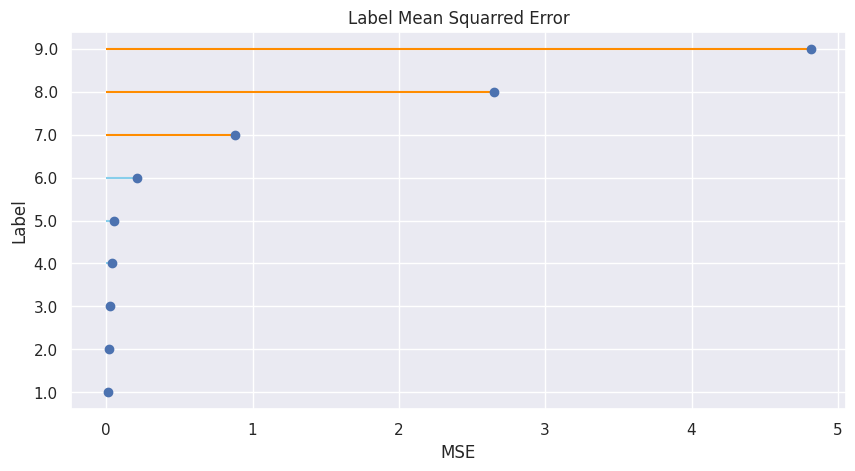

In [ ]:
df_acc['label'] = np.around(trainset.scaler.inverse_transform(df_acc['label_norm'].values.reshape(-1, 1)).squeeze())
#print(df_acc.groupby(['label'])['forward', 'morpho'].mean())

df_results = df_acc.groupby(['label'])['forward', 'morpho'].mean()
print(df_results)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

my_range=range(1,len(df_results.index)+1)
plt.subplots(figsize=(10,5), dpi=100)
plt.hlines(y=my_range, xmin=0, xmax=df_results['forward'], color=['skyblue',
                                                                  'skyblue',
                                                                  'skyblue',
                                                                  'skyblue',
                                                                  'skyblue',
                                                                  'skyblue',
                                                                  'darkorange',
                                                                  'darkorange',
                                                                  'darkorange'])
plt.plot(df_results['forward'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, df_results.index)
plt.title("Label Mean Squarred Error")
plt.xlabel('MSE')
plt.ylabel('Label')

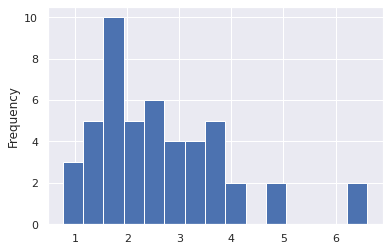

In [ ]:
df_acc[df_acc['label']==8]['forward'].plot.hist(bins=15)


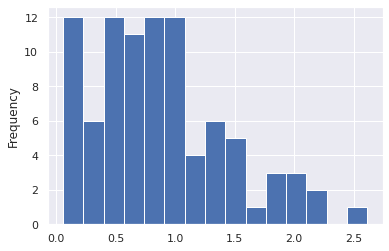

In [ ]:
df_acc[df_acc['label']==7]['forward'].plot.hist(bins=15)


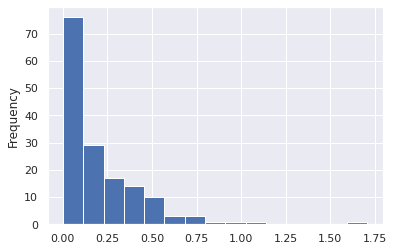

In [ ]:
df_acc[df_acc['label']==6]['forward'].plot.hist(bins=15)

# Monter Carlo inference

In [ ]:
from src.inference import monte_carlo_inference

In [ ]:
generator = best_generator_in_distribution

In [ ]:
monte_carlo_inference(9, generator, forward, trainset, fulldataset, sample_number = 300)

  0%|          | 0/300 [00:00<?, ?img/s]Process ForkPoolWorker-243:
Process ForkPoolWorker-242:
Process ForkPoolWorker-244:
Process ForkPoolWorker-241:


KeyboardInterrupt: ignored

In [ ]:
monte_carlo_inference(8, generator, forward, trainset, fulldataset, sample_number = 600)

In [ ]:
monte_carlo_inference(7, generator, forward, trainset, fulldataset, sample_number = 1000)

In [ ]:
monte_carlo_inference(6, generator, forward, trainset, fulldataset, sample_number = 2000)


100%|##########| 2000/2000 [01:51<00:00, 17.93img/s]

100%|##########| 4/4 [00:00<00:00,  8.58img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.2927919183535529
MSE morpho on Generated data: 1.618456526261352


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.9996405



FID: 100%|██████████| 10/10 [00:00<00:00, 35.60it/s, mean=16.5]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 35.12it/s, mean=0.357]


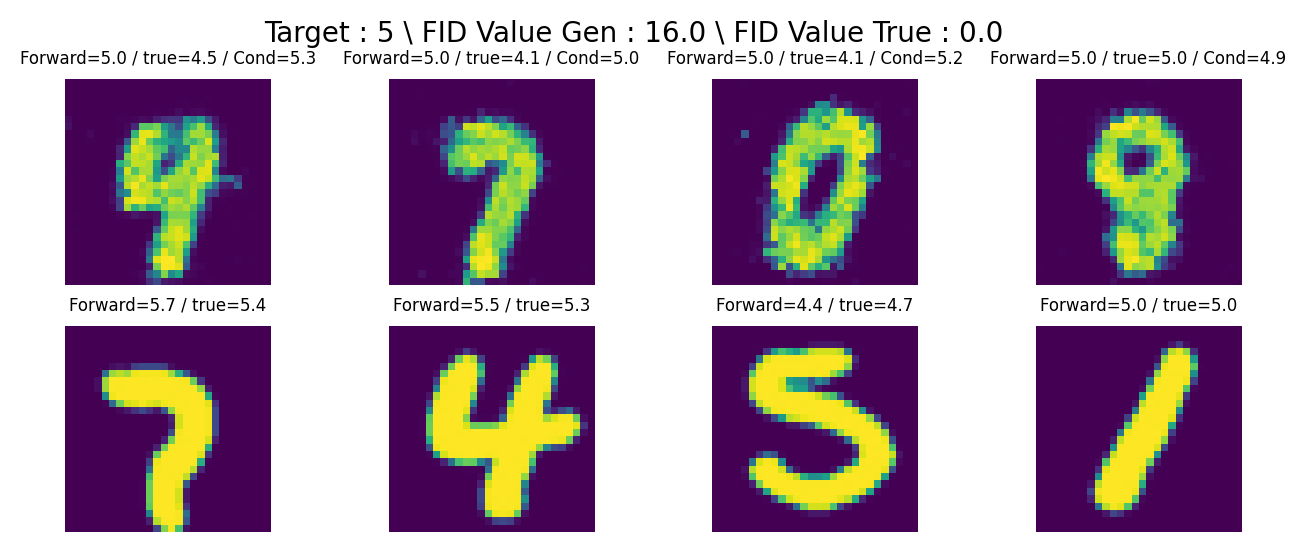

In [ ]:
inf_best_5, mean_sample_measure_5, fid_gen_5 = monte_carlo_inference(5, generator, forward, trainset, fulldataset, sample_number = 2000)


100%|##########| 2000/2000 [01:50<00:00, 18.04img/s]

100%|##########| 4/4 [00:00<00:00,  8.10img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.2671367088776216
MSE morpho on Generated data: 1.5560671824203192


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.99890745



FID: 100%|██████████| 10/10 [00:00<00:00, 33.74it/s, mean=15.8]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 33.68it/s, mean=0.56]


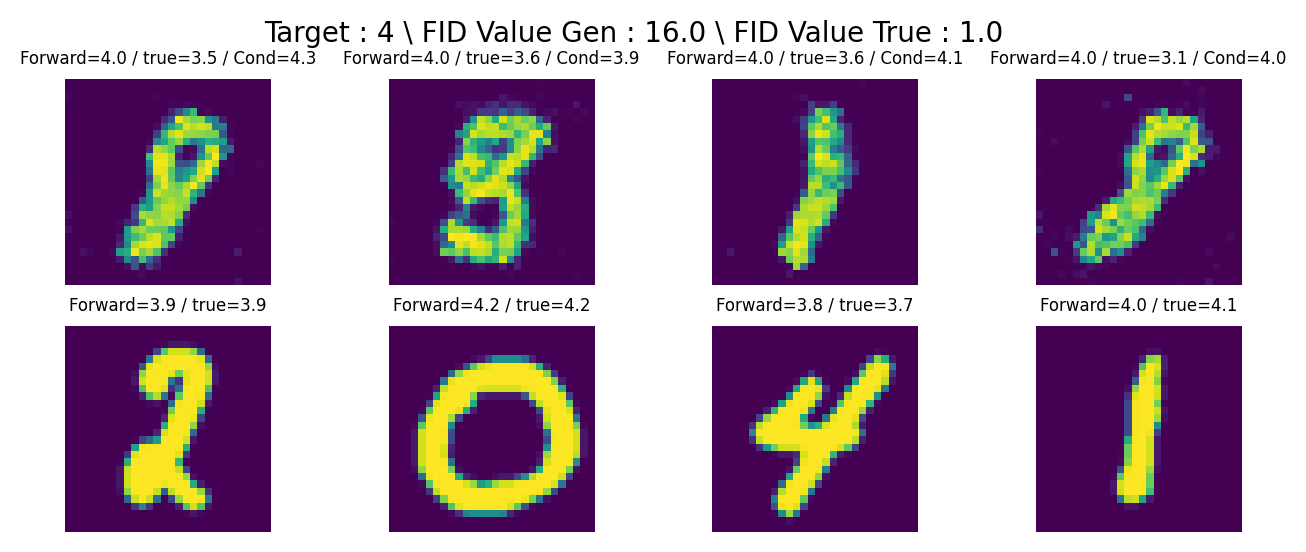

In [ ]:
inf_best_4, mean_sample_measure_4, fid_gen_4 = monte_carlo_inference(4, generator, forward, trainset, fulldataset, sample_number = 2000)


100%|##########| 2000/2000 [01:49<00:00, 18.20img/s]

100%|##########| 4/4 [00:00<00:00, 11.79img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.6264442405724361
MSE morpho on Generated data: 1.3155935417535038


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.99858594



FID: 100%|██████████| 10/10 [00:00<00:00, 35.50it/s, mean=14.3]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 35.42it/s, mean=0.412]


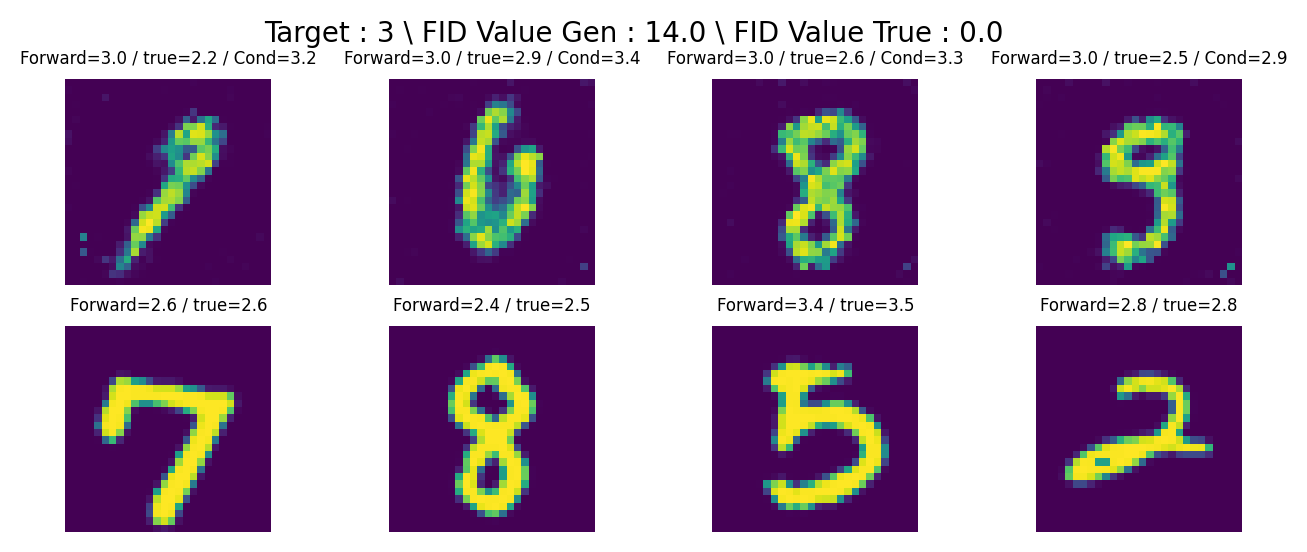

In [ ]:
inf_best_3, mean_sample_measure_3, fid_gen_3 = monte_carlo_inference(3, generator, forward, trainset, fulldataset, sample_number = 2000)


100%|##########| 2000/2000 [01:50<00:00, 18.16img/s]

100%|##########| 4/4 [00:00<00:00, 11.43img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.04109108778458156
MSE morpho on Generated data: 0.6957702923107782


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.9947518



FID: 100%|██████████| 10/10 [00:00<00:00, 32.36it/s, mean=15.3]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 36.25it/s, mean=0.412]


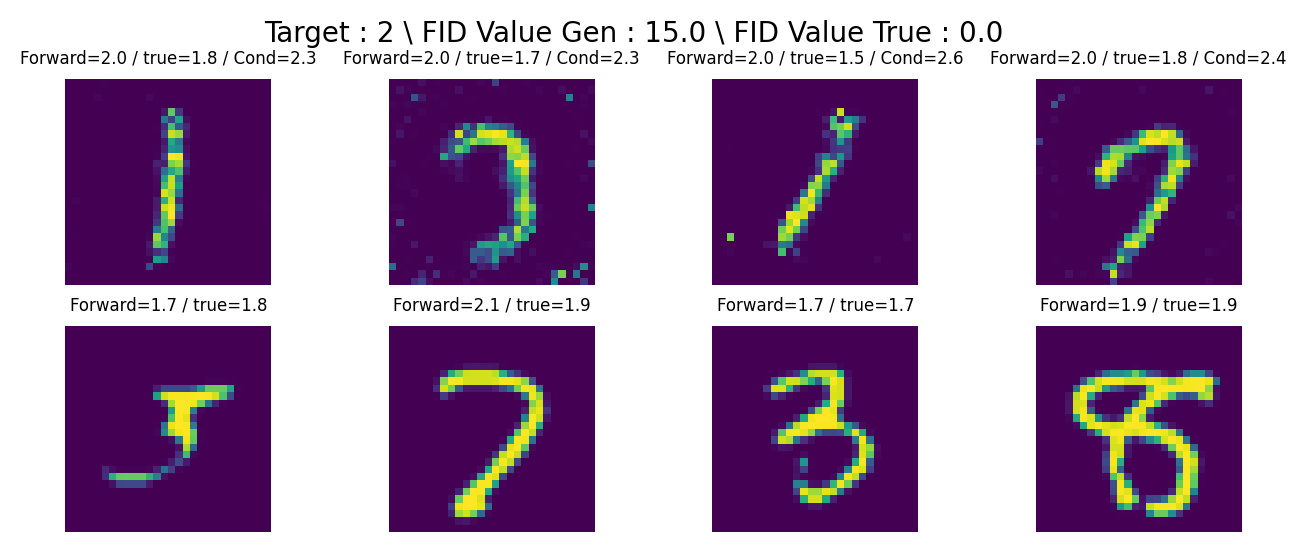

In [ ]:
inf_best_2, mean_sample_measure_2, fid_gen_2 = monte_carlo_inference(2, generator, forward, trainset, fulldataset, sample_number = 2000)


100%|##########| 2000/2000 [01:50<00:00, 18.16img/s]

100%|##########| 4/4 [00:00<00:00,  8.75img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.012670306137530247
MSE morpho on Generated data: 0.21309990093545542


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.995452



FID: 100%|██████████| 10/10 [00:00<00:00, 33.01it/s, mean=20.2]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 33.90it/s, mean=0.529]


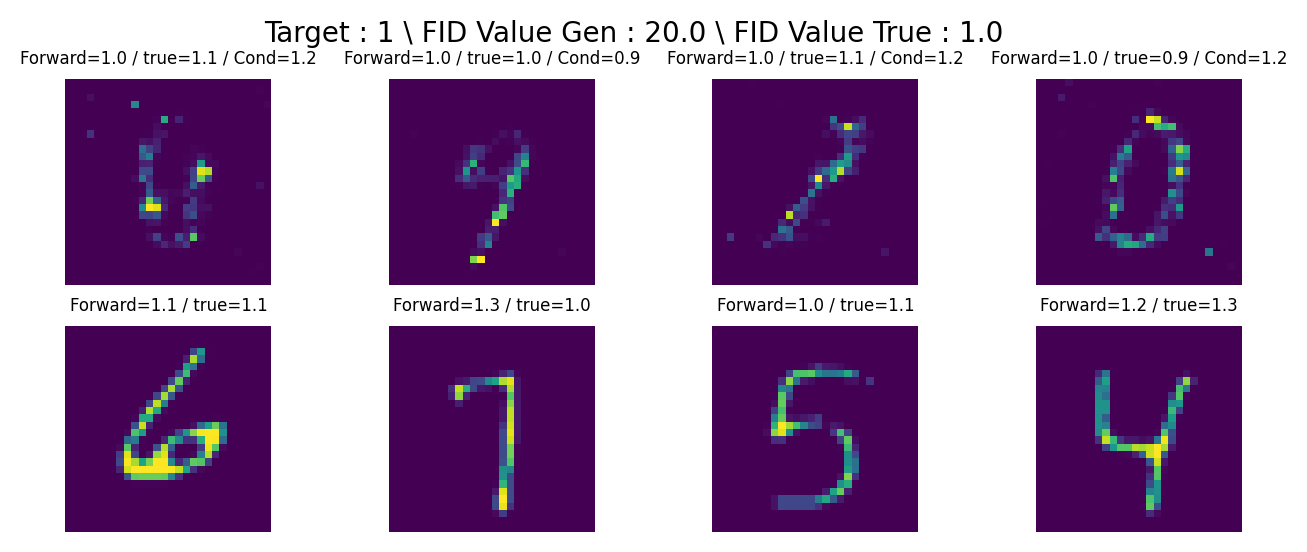

In [ ]:
inf_best_1, mean_sample_measure_1, fid_gen_1 = monte_carlo_inference(1, generator, forward, trainset, fulldataset, sample_number = 2000)

In [ ]:
generator = best_generator_out_distribution


100%|##########| 300/300 [00:17<00:00, 17.02img/s]

100%|##########| 4/4 [00:00<00:00,  9.20img/s]


 ------------ Best forward image ------------
MSE measure pred = 15.693929430621605
MSE morpho on Generated data: 22.685014490794217


(300, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=33.8]

(300, 1, 32, 32) 0.0 0.99995476



FID: 100%|██████████| 10/10 [00:00<00:00, 35.66it/s, mean=32.9]


(300, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy



FID:   0%|          | 0/10 [00:00<?, ?it/s, mean=1.22]

(300, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 36.28it/s, mean=1.34]


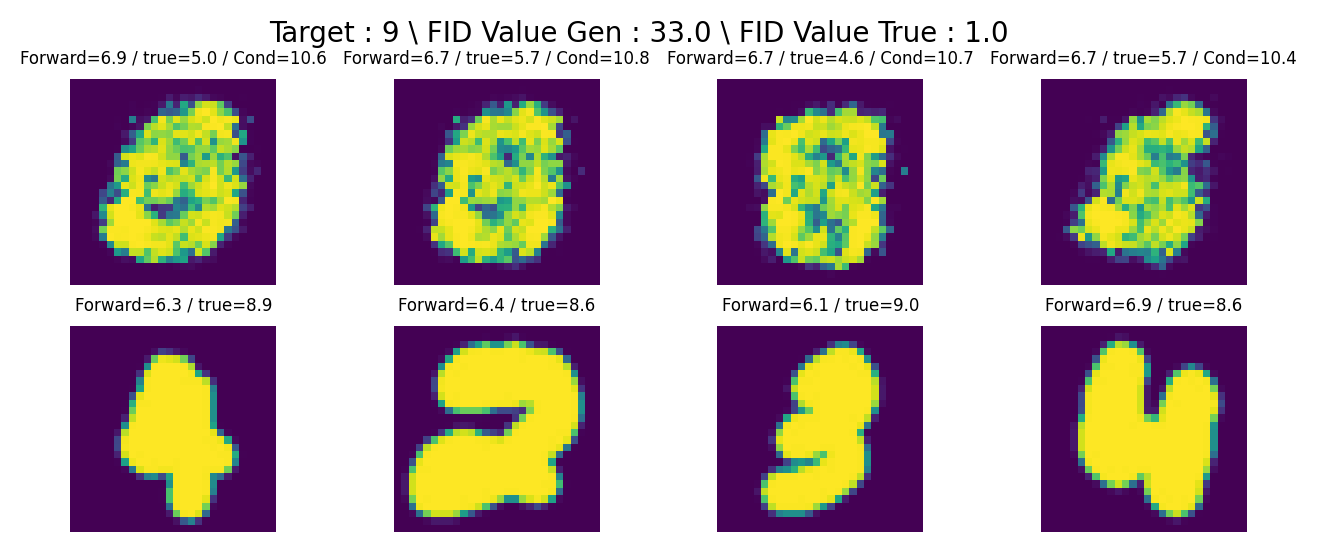

In [ ]:
inf_best_9, mean_sample_measure_9, fid_gen_9 = monte_carlo_inference(9, generator, forward, trainset, fulldataset, sample_number = 300)


100%|##########| 600/600 [00:34<00:00, 17.19img/s]

100%|##########| 4/4 [00:00<00:00, 12.03img/s]


 ------------ Best forward image ------------
MSE measure pred = 5.756458937284639
MSE morpho on Generated data: 13.684621324527923


(600, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(600, 1, 32, 32) 0.0 0.99971455



FID: 100%|██████████| 10/10 [00:00<00:00, 35.85it/s, mean=30.5]


(600, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(600, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 36.91it/s, mean=0.932]


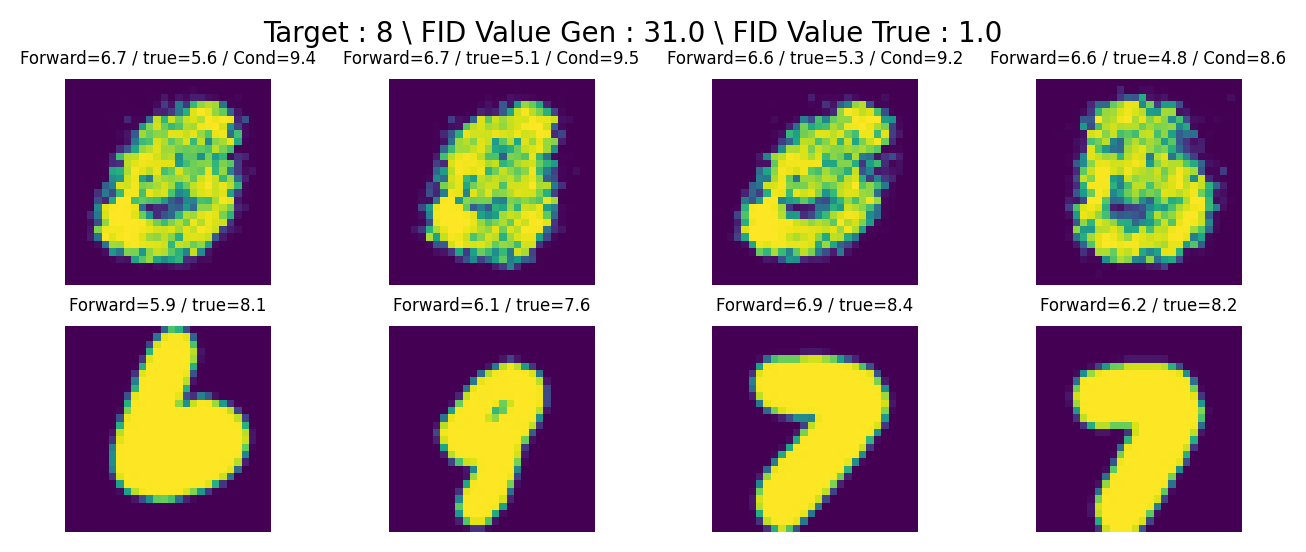

In [ ]:
inf_best_8, mean_sample_measure_8, fid_gen_8 = monte_carlo_inference(8, generator, forward, trainset, fulldataset, sample_number = 600)


100%|##########| 1000/1000 [00:57<00:00, 17.46img/s]

100%|##########| 4/4 [00:00<00:00,  8.98img/s]


 ------------ Best forward image ------------
MSE measure pred = 4.9280653658182265
MSE morpho on Generated data: 7.294698172117688


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 2.9808128e-08 0.9998757



FID: 100%|██████████| 10/10 [00:00<00:00, 34.90it/s, mean=27.1]


(1000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1000, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 37.23it/s, mean=0.687]


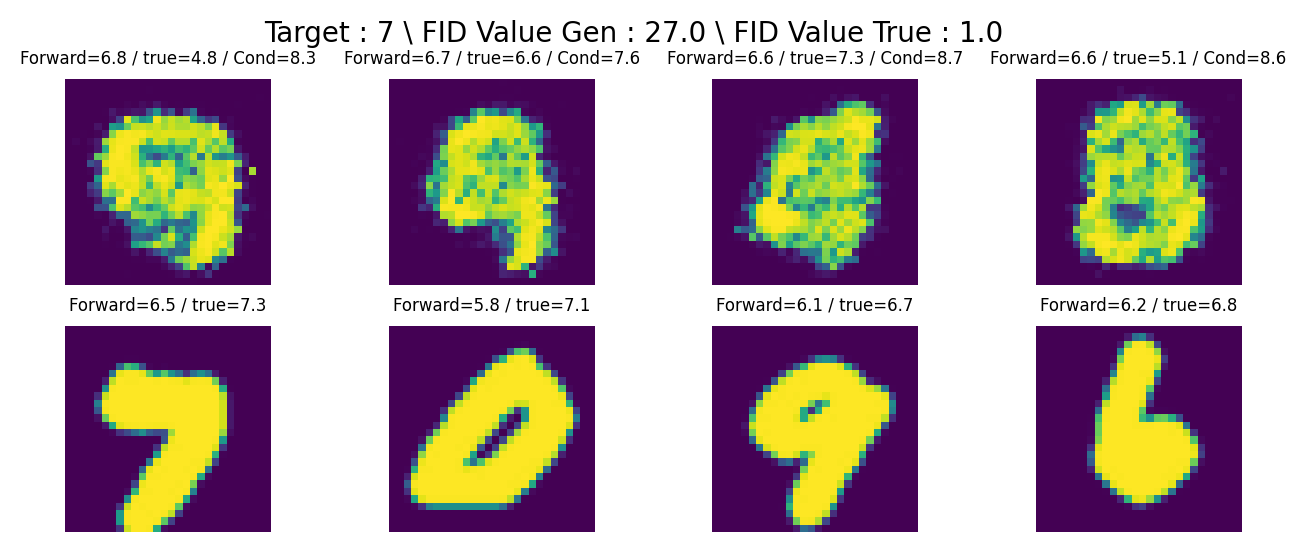

In [ ]:
inf_best_7, mean_sample_measure_7, fid_gen_7 = monte_carlo_inference(7, generator, forward, trainset, fulldataset, sample_number = 1000)


100%|##########| 2000/2000 [01:51<00:00, 17.99img/s]

100%|##########| 4/4 [00:00<00:00, 11.24img/s]


 ------------ Best forward image ------------
MSE measure pred = 1.617917889894503
MSE morpho on Generated data: 3.5887689223655315


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.99968463



FID: 100%|██████████| 10/10 [00:00<00:00, 36.99it/s, mean=19.1]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0



FID: 100%|██████████| 10/10 [00:00<00:00, 36.26it/s, mean=0.29]


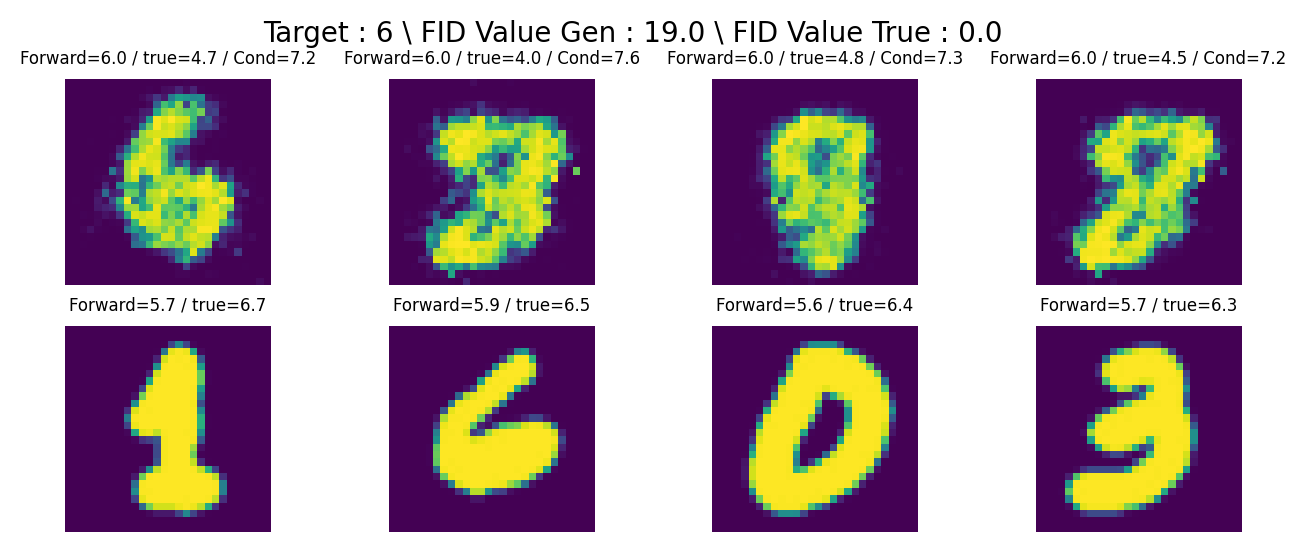

In [ ]:
inf_best_6, mean_sample_measure_6, fid_gen_6 = monte_carlo_inference(6, generator, forward, trainset, fulldataset, sample_number = 2000)

100%|##########| 4/4 [00:00<00:00,  6.64img/s]


 ------------ Best forward image ------------
MSE measure pred = 2.688102091722096
MSE morpho on Generated data: 1.8782967266038304


(800, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(800, 1, 32, 32) 0.0 0.998704


FID: 100%|██████████| 10/10 [00:00<00:00, 29.47it/s, mean=19]


(800, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(800, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 30.40it/s, mean=0.705]


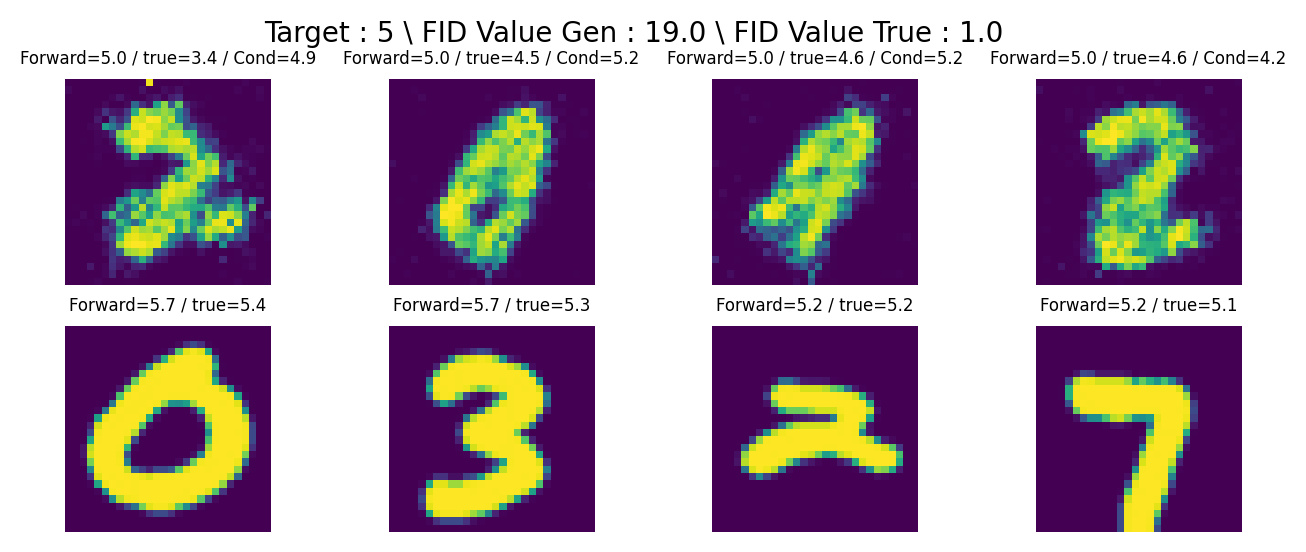

(2.688102091722096, 1.8782967266038304, 18.994745647649506)

In [ ]:
monte_carlo_inference(5, generator, forward, trainset, fulldataset, sample_number = 2000)

100%|##########| 4/4 [00:00<00:00,  6.60img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.7373011163714159
MSE morpho on Generated data: 1.5502470083782065


(1200, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1200, 1, 32, 32) 0.0 0.99929005


FID: 100%|██████████| 10/10 [00:00<00:00, 29.84it/s, mean=16.7]


(1200, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1200, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 28.69it/s, mean=0.474]


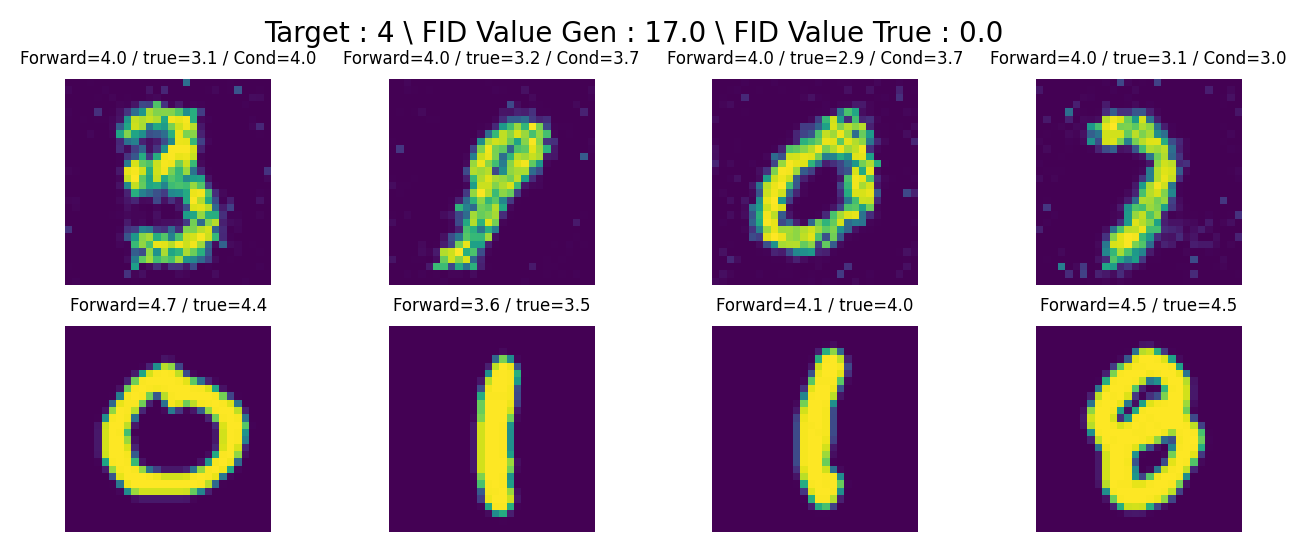

(0.7373011163714159, 1.5502470083782065, 16.727472816114783)

In [ ]:
monte_carlo_inference(4, generator, forward, trainset, fulldataset, sample_number = 2000)

100%|##########| 4/4 [00:00<00:00,  6.75img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.36732331756
MSE morpho on Generated data: 1.4513103349568663


(1250, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1250, 1, 32, 32) 0.0 0.9985265


FID: 100%|██████████| 10/10 [00:00<00:00, 28.91it/s, mean=15.5]


(1250, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(1250, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 28.53it/s, mean=0.594]


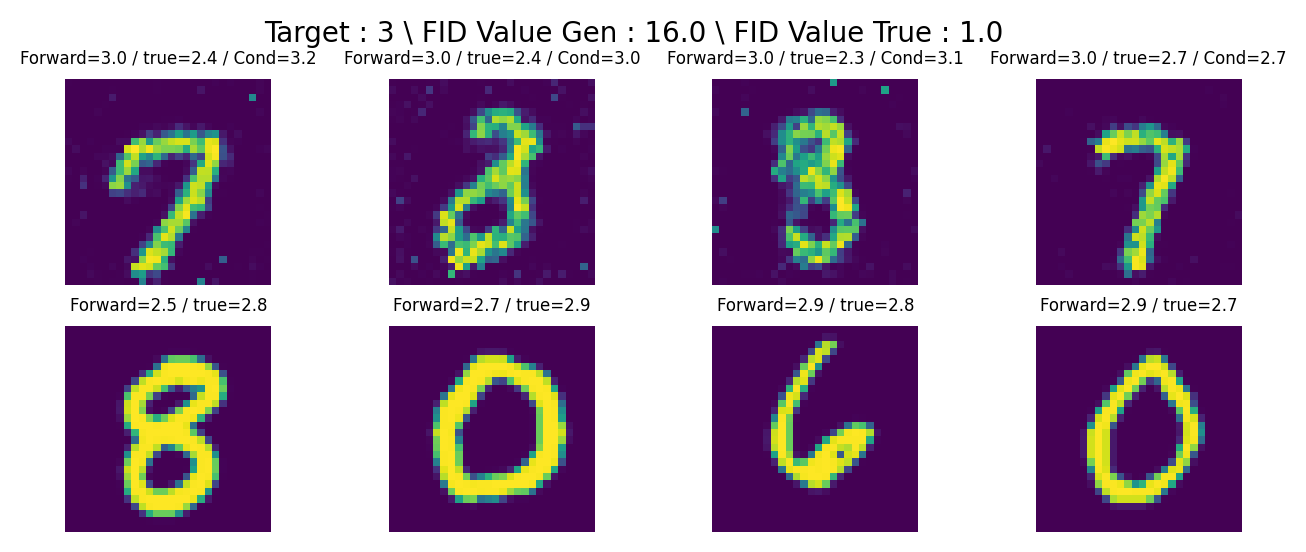

(0.36732331756, 1.4513103349568663, 15.548208310702762)

In [ ]:
monte_carlo_inference(3, generator, forward, trainset, fulldataset, sample_number = 2000)

100%|##########| 4/4 [00:00<00:00,  7.08img/s]


 ------------ Best forward image ------------
MSE measure pred = 0.004196802092098069
MSE morpho on Generated data: 0.7169989926665067


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 0.9962828


FID: 100%|██████████| 10/10 [00:00<00:00, 28.32it/s, mean=16.7]


(2000, 1, 32, 32) 0.0 1.0
save_data/gen_img_in_distribution.npy
(2000, 1, 32, 32) 0.0 1.0


FID: 100%|██████████| 10/10 [00:00<00:00, 28.15it/s, mean=0.285]


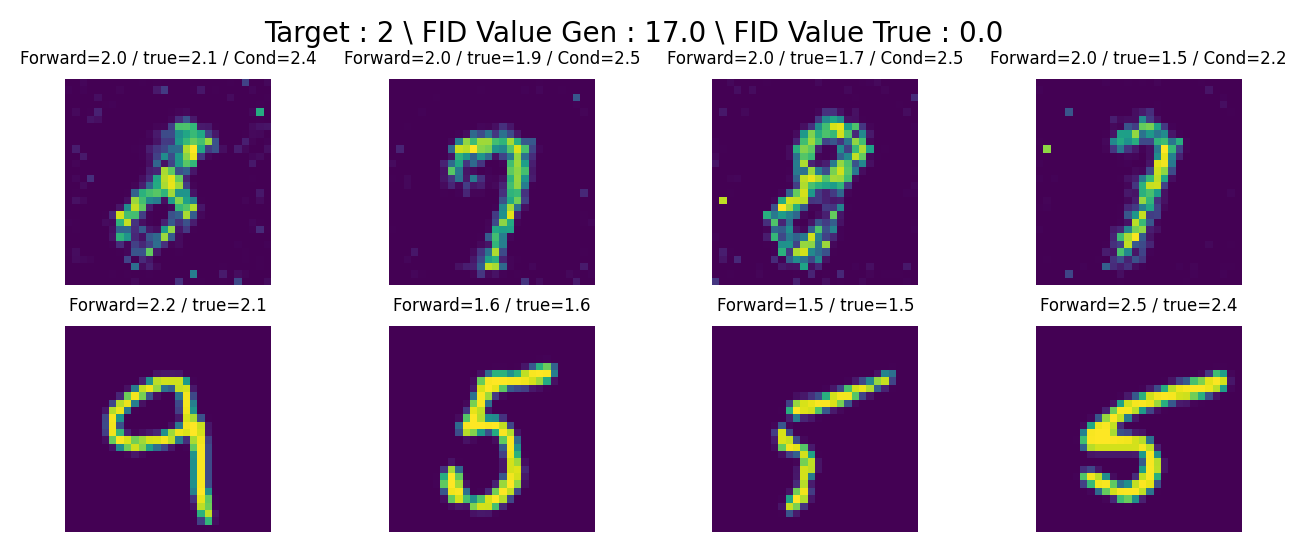

(0.004196802092098069, 0.7169989926665067, 16.66548369997819)

In [ ]:
monte_carlo_inference(2, generator, forward, trainset, fulldataset, sample_number = 2000)

In [ ]:
monte_carlo_inference(1, generator, forward, trainset, fulldataset, sample_number = 2000)

 40%|####      | 801/2000 [01:22<2:16:38,  6.84s/img]Process ForkPoolWorker-313:
Process ForkPoolWorker-316:
Process ForkPoolWorker-314:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-315:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line

KeyboardInterrupt: ignored

In [ ]:
# Print results
in_distribution_wo_inf = (mean_sample_measure_5 + mean_sample_measure_4 + mean_sample_measure_3 + mean_sample_measure_2)/4 #+ mean_sample_measure_1)/5
in_distribution_full_model = (inf_best_5 + inf_best_4 + inf_best_3 + inf_best_2)/4 #+ inf_best_1)/5
out_distribution_wo_inf = (mean_sample_measure_9 + mean_sample_measure_8 + mean_sample_measure_7 + mean_sample_measure_6)/4 
out_distribution_full_model = (inf_best_9 + inf_best_8 + inf_best_7 + inf_best_6)/4 
fid_in_distribution = (fid_gen_5 + fid_gen_4 + fid_gen_3 + fid_gen_2)/4 #+ fid_gen_1)/5
fid_out_distribution = (fid_gen_9 + fid_gen_8 + fid_gen_7 + fid_gen_6)/4 
print(f' ------------------ wo IS \ Naive ------------------ ')
print(f' ACC in = {in_distribution_full_model}   /   ACC in = {in_distribution_wo_inf} ')
print(f' ACC out = {out_distribution_full_model}   /   ACC out = {out_distribution_wo_inf} ')
print(f" FID in = {fid_in_distribution}\n FID out = {fid_out_distribution}")

 ------------------ wo IS \ Naive ------------------ 
 ACC in = 0.3068659888970481   /   ACC in = 1.2964718856864885 
 ACC out = 6.999092905904743   /   ACC out = 11.813275727451341 
 FID in = 15.471496444256989
 FID out = 27.422452455813186
